In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts

In [2]:

klab = 2*np.pi*25068.2222# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
taulab = 1/(1.93*1e8)
v0 = 300#cm^-1
Blab = (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
mass_lab = 173*cts.value('atomic mass constant')# T # About 15 G/cm is a typical gradient for Rb
L = 100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab)
print(Blab, L)

0.05373203094365263 16.12986868284397


In [28]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = taulab  # s

mass = masslab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
l = L/x0

print(x0, t0, mass, k, gamma, alpha)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 24.48315317163002


In [33]:
alpha

24.48315317163002

In [56]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 1,  1.3426,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035, 1.3426,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1)#excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)


dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

det = 25
s = 1.5

# Define the laser beams:
laserBeams = pylcp.laserBeams([
     {'kvec':np.array([-1., 0., 0.]), 's':1.5, 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) - det*gamma}],
    beam_type=pylcp.infinitePlaneWaveBeam)

# Define the magnetic field:
linGrad = pylcp.magField(lambda R: alpha*(1-np.sqrt(1-R/l)))

In [57]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)

In [58]:
vc = x0/t0*(1/100)
x = np.arange(0, L, 0.4)/(x0)
v = np.arange(0, 400,400/41)/vc


X, V = np.meshgrid(x, v)

Rvec = np.array([X, np.zeros(X.shape), np.zeros(X.shape)])
Vvec = np.array([V, np.zeros(V.shape), np.zeros(V.shape)])

rateeq.generate_force_profile(Rvec, Vvec, name='Fx', progress_bar=True)

Completed in 1.95 s.                                               


C:\Users\benfo\AppData\Local\Temp\ipykernel_25164\4181122366.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = plt.cm.get_cmap('viridis_r')


Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

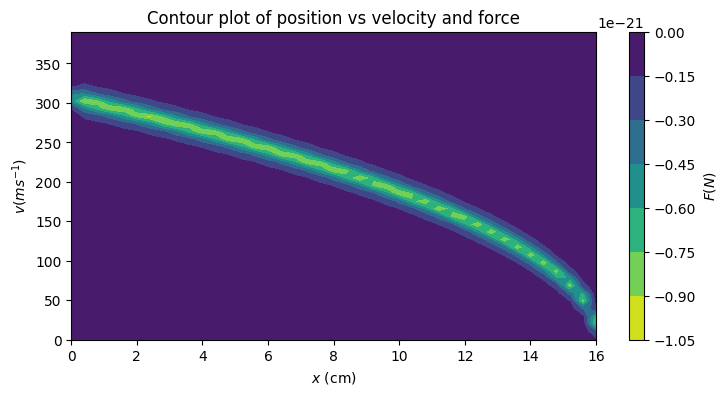

In [68]:
fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab
im1 = ax.contourf(X*x0, V*vc, rateeq.profile['Fx'].F[0]*Fc, cmap =cmap_reversed)
fig.subplots_adjust(left=0.08, wspace=0.2)
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

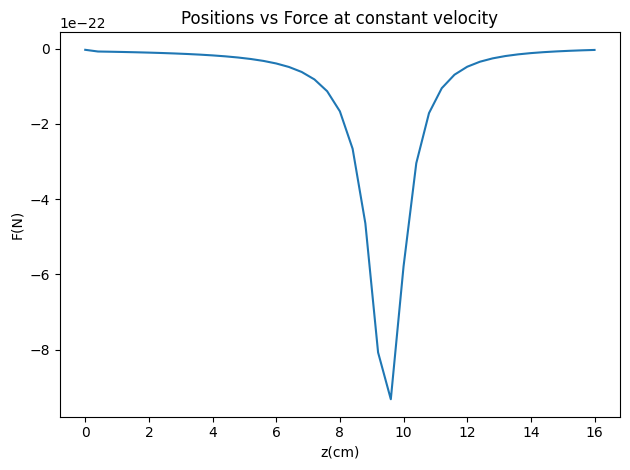

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, num="Expression",sharey = False)
const = x0**3/cts.hbar*t0**3
ax.plot(x*x0, rateeq.profile['Fx'].F[0][int(len(v)/2),:]*Fc)
ax.set_xlabel('z(cm)')
ax.set_ylabel('F(N)')
plt.title('Positions vs Force at constant velocity')
plt.tight_layout()

In [65]:
tmax = 0.05/t0
n0 = np.zeros((rateeq.hamiltonian.n,))
n0[5] = 1
if isinstance(rateeq, pylcp.rateeq):
    rateeq.set_initial_pop(n0)
rateeq.set_initial_position(np.array([0., 0., 0.]))
rateeq.set_initial_velocity(np.array([10, 10, 100]))
rateeq.evolve_motion([0, 0.0005/t0], random_recoil=False, progress_bar=True, max_step=1.)

c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Rijl[key][ll] = gamma*intensity/2*\


c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\hamiltonian.py:232: SyntaxWarning: invalid escape sequence '\m'
  """
c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\hamiltonian.py:474: SyntaxWarning: invalid escape sequence '\m'
  """


KeyboardInterrupt: 